#Using Deep Learning To Clone Driver Behavior


In [1]:
"""
Steering angle prediction model
"""

#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from PIL import Image
import keras
import math
import random
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop
from scipy.misc.pilutil import imresize
from sklearn.utils import shuffle
import cv2

import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [2]:
import pandas as pd
data = pd.read_csv('driving_log.csv', header = None)
data.columns = ["center_images","left_images","right_images","steering","brake","throttle","speed"]
len(data)

8036

In [3]:
X_train = np.copy(data['center_images']+':'+data['left_images']+':'+data['right_images'])
Y_train = np.copy(data['steering'])

In [4]:
len(X_train)

8036

This image is: <class 'numpy.ndarray'> with dimesions: (160, 320, 3)


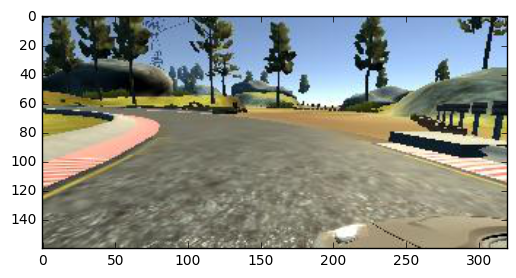

In [5]:
#reading in an image
image = mpimg.imread('IMG/left_2016_12_01_13_31_13_584.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  

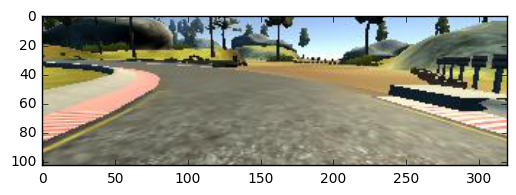

In [6]:
oriimage = mpimg.imread('IMG/left_2016_12_01_13_31_13_584.jpg', 1)
#crop face before resize
# crop 20% from bottom to remove car hood and 25 pixels from top
crop_face = oriimage[32:135, :] 
plt.imshow(crop_face)

In [7]:
crop_face.shape

(103, 320, 3)

In [8]:
#Resize to image to half or 65% of cropped image
newimage = imresize(crop_face, .65, interp='bilinear', mode=None)
newimage.shape

(66, 208, 3)

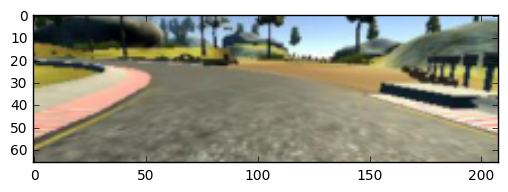

In [9]:
plt.imshow(newimage)

In [10]:
type(oriimage[0][0][0])

numpy.uint8

In [11]:
oriimage = oriimage/255 - .5

In [12]:
type(oriimage[0][0][0])

numpy.float64

In [13]:
np.max(oriimage)

0.5

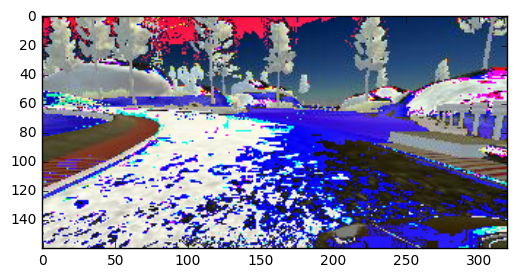

In [14]:
#color type image sent to the fit_generator 
# that matches the drive.py color images
plt.imshow(oriimage)

In [15]:
def load_image(imagepath):
    
    oriimage = mpimg.imread(imagepath, 1)
    #crop face before resize
    #Remove 20% from the bottom to eliminate the car hood
    # 25 pixels from the top to concentrate on the road
    crop_face = oriimage[32:135, :]
    #Resize to image to half or 65% of cropped image
    newimage = imresize(crop_face, .65, interp='bilinear', mode=None)
    newimage = newimage/255-0.5
    return newimage

In [16]:
def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(208,66))
    return image_tr,steer_ang

In [17]:
def flip_image(image):
    flipimage = np.fliplr(image)
    return flipimage

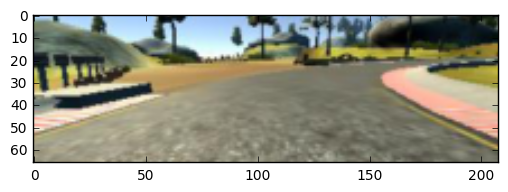

In [18]:
flipimage = np.fliplr(newimage)
plt.imshow(flipimage)

In [19]:
nb_epoch = 7
number_of_rows = 8032
image_rows = 66
image_columns = 208
image_channels = 3
batch_images = np.zeros((number_of_rows, image_rows, image_columns, image_channels))
batch_steering = np.zeros(number_of_rows)

In [20]:
def remove_low_steering_angles(x,y): 
    image = []
    steer_angle = []
    for xi, yi in zip(x, y):
        probability = random.random()
        if (probability > 0.5 or abs(yi) > 0.01):
            image.append(xi)
            steer_angle.append(yi)

    image = np.array(image)
    steer_angle = np.array(steer_angle)
    return image, steer_angle

In [21]:
x_train_less, y_train_less = remove_low_steering_angles(X_train,Y_train)

In [22]:
hist, bins = np.histogram(y_train_less, bins=np.arange(30), density=True)

In [23]:
def batchgen(X,Y):
    
    trans_range = 100
    steer_angle = []
    counter  = 0 
    while counter < len(X):
        
         
        if counter==len(X):
            counter  = 0
            X, Y = shuffle(X, Y, random_state=0)
        for counter in range(len(X)): 
            y = Y[counter]
           
            if y <  0.01:
                chance = random.random()
                if chance > 0.75:
                    imagepath = X[counter].split(':')[2]
                    image = load_image(imagepath)
                    image, y = trans_image(image,y,trans_range)
                    y = y - .25
                else:
                    if chance > 0.49:
                        imagepath = X[counter].split(':')[2]
                        image = load_image(imagepath)
                        image, y = trans_image(image,y,trans_range)
                        y = y - .25
                    else:
                        if chance > 24:
                            imagepath = X[counter].split(':')[0]
                            image = load_image(imagepath)
                          
                        else:
                            imagepath = X[counter].split(':')[0]
                            image = load_image(imagepath)
                            
            elif y > 0.01:
                chance = random.random()
                if chance > 0.75:
                    imagepath = X[counter].split(':')[1]
                    image = load_image(imagepath)
                    image, y = trans_image(image,y,trans_range)
                    y = y + .25
                else:
                    if chance > 0.49:
                        imagepath = X[counter].split(':')[1]
                        image = load_image(imagepath)
                        image, y = trans_image(image,y,trans_range)
                        y = y + .25
                    else:
                        if chance > 0.24:
                            imagepath = X[counter].split(':')[0]
                            image = load_image(imagepath)
                      
                        else:
                            imagepath = X[counter].split(':')[0]
                            image = load_image(imagepath)
                     
                                    
            else:
                imagepath = X[counter].split(':')[0]
                image = load_image(imagepath)
                  
            
            y = np.array([[y]])
                
            if np.random.choice([True, False]):
                image = flip_image(image)
                y = -y
            
            image = image.reshape(1, image_rows, image_columns, image_channels)
            yield image, y  
            
        
      

In [24]:
def get_model():

    input_shape = (image_rows, image_columns, image_channels)
    model = Sequential()
    model.add(Convolution2D(24,5,5, input_shape=input_shape, subsample = (2,2),
                        border_mode='same',
                        name='conv1', init='he_normal'))
    model.add(ELU())

    model.add(Convolution2D(36,5,5, subsample = (2,2),
                        border_mode='same',
                        name='conv2', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(48,5,5, subsample = (2,2),
                        border_mode='valid',
                        name='conv3', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, subsample = (1,1),
                        border_mode='valid',
                        name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, subsample = (1,1),
                        border_mode='valid',
                        name='conv5', init='he_normal'))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(100,name='hidden1', init='he_normal'))
    model.add(ELU())
    model.add(Dense(50,name='hidden2', init='he_normal'))
    model.add(ELU())
    model.add(Dense(10,name='hidden3',init='he_normal'))
    model.add(ELU())
    model.add(Dense(1, name='output', init='he_normal'))
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='mse')
    return model

In [25]:
model = get_model()

In [26]:
samples_per_epoch = len(x_train_less)

In [27]:
# checkpoint
checkpoint = ModelCheckpoint("model-{epoch:02d}.h5", monitor='loss', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]


In [28]:
max_q_size = 32

In [29]:
history = model.fit_generator(batchgen(x_train_less, y_train_less), samples_per_epoch = samples_per_epoch, nb_epoch = nb_epoch,
                    verbose=1, max_q_size = max_q_size, callbacks=callbacks_list, validation_data=None, class_weight=None,
                     pickle_safe=False)

Epoch 1/7
5853/5853 [==============================] - 69s - loss: 0.0534    
Epoch 2/7
5853/5853 [==============================] - 66s - loss: 0.0404    
Epoch 3/7
5853/5853 [==============================] - 66s - loss: 0.0326    
Epoch 4/7
5853/5853 [==============================] - 66s - loss: 0.0283    
Epoch 5/7
5853/5853 [==============================] - 66s - loss: 0.0282    
Epoch 6/7
5853/5853 [==============================] - 66s - loss: 0.0270    
Epoch 7/7
5853/5853 [==============================] - 66s - loss: 0.0263    


In [30]:
model.predict_generator(batchgen(x_train_less, y_train_less), 20, max_q_size=10, nb_worker=1, pickle_safe=False)

array([[-0.21614768],
       [ 0.30318108],
       [ 0.2120163 ],
       [ 0.21702516],
       [-0.09167372],
       [ 0.23514315],
       [ 0.23911729],
       [-0.24711478],
       [-0.40386653],
       [ 0.44630668],
       [ 0.18407303],
       [ 0.29362667],
       [-0.12705886],
       [ 0.14352602],
       [ 0.1431026 ],
       [-0.41293606],
       [-0.03344464],
       [ 0.01007126],
       [ 0.04625968],
       [-0.19063263]], dtype=float32)

In [31]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1 (Convolution2D)            (None, 33, 104, 24)   1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 33, 104, 24)   0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 17, 52, 36)    21636       elu_1[0][0]                      
____________________________________________________________________________________________________
elu_2 (ELU)                      (None, 17, 52, 36)    0           conv2[0][0]                      
___________________________________________________________________________________________

In [32]:


model.save_weights("model.h5", True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)
    
print("Saved model weights and configuration file.")

Saved model weights and configuration file.
